In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

## Load dataset

In [2]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision.transforms import transforms

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
])

dataset_path = 'train'
dataset = ImageFolder(root=dataset_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=512)

## Feature extraction
We utilize the DINOv2 model for feature extraction due to its state-of-the-art performance in generating high-quality image embeddings. DINOv2 leverages self-supervised learning with vision transformers to produce rich and discriminative features, which are essential for effective clustering. By harnessing DINOv2 embeddings, we aim to achieve superior clustering results, capturing the intricate visual patterns and structures within the images, thus facilitating more accurate and meaningful grouping of similar images.

In [3]:
dinov2_vitb14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitb14')

Using cache found in /home/igor/.cache/torch/hub/facebookresearch_dinov2_main
/home/igor/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/home/igor/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/home/igor/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


In [5]:
from tqdm import tqdm

embeddings = []

with torch.no_grad():
    for images, _ in tqdm(dataloader):
        embedding = dinov2_vitb14(images)
        embeddings.append(embedding)
    
embeddings = torch.cat(embeddings, dim=0)
print(f"Embeddings matrix shape: {embeddings.shape}")

100%|██████████| 31/31 [1:03:45<00:00, 123.41s/it]


Embeddings matrix shape: torch.Size([15557, 768])


In [6]:
embeddings = embeddings.numpy()
np.save('embeddings_dino_base.npy', embeddings)

## Dimensionality reduction
We experiment with reducing the dimensionality of the extracted embeddings using PCA (Principal Component Analysis) and UMAP (Uniform Manifold Approximation and Projection) algorithms. Dimensionality reduction is crucial for visualizing high-dimensional data and enhancing the efficiency of subsequent clustering algorithms. PCA, a linear technique, reduces dimensions by projecting data onto the directions of maximum variance, preserving global structures. In contrast, UMAP, a non-linear method, focuses on maintaining the local neighborhood relationships, providing a more meaningful representation of the data's intrinsic geometry. By comparing PCA and UMAP, we aim to identify the most effective technique for retaining essential image features while reducing complexity, ultimately improving the clustering performance.

In [ ]:
embeddings = np.load('embeddings_dino_base.npy')

In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
embeddings = scaler.fit_transform(embeddings)

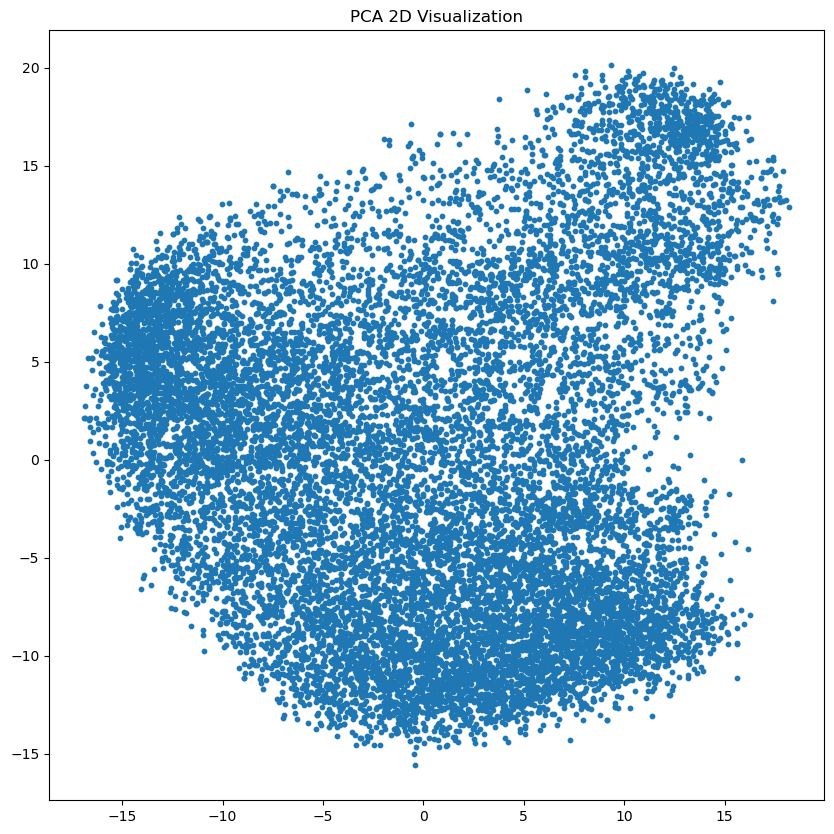

In [11]:
# pca 2d visualization
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=42)
reduced = pca.fit_transform(embeddings)

plt.figure(figsize=(10, 10))
plt.scatter(reduced[:, 0], reduced[:, 1], s=10)
plt.title('PCA 2D Visualization')
plt.show()

/home/igor/anaconda3/envs/dermnet/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


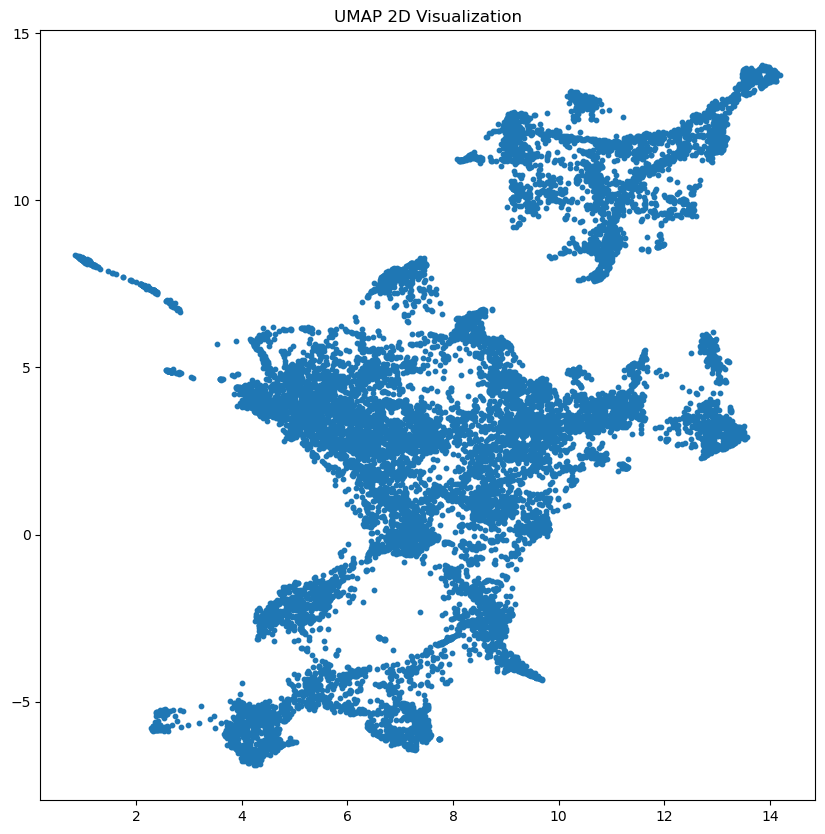

In [10]:
import umap

reducer = umap.UMAP(n_components=2, random_state=42)
reduced = reducer.fit_transform(embeddings_scaled)

plt.figure(figsize=(10, 10))
plt.scatter(reduced[:, 0], reduced[:, 1], s=10)
plt.title('UMAP 2D Visualization')
plt.show()

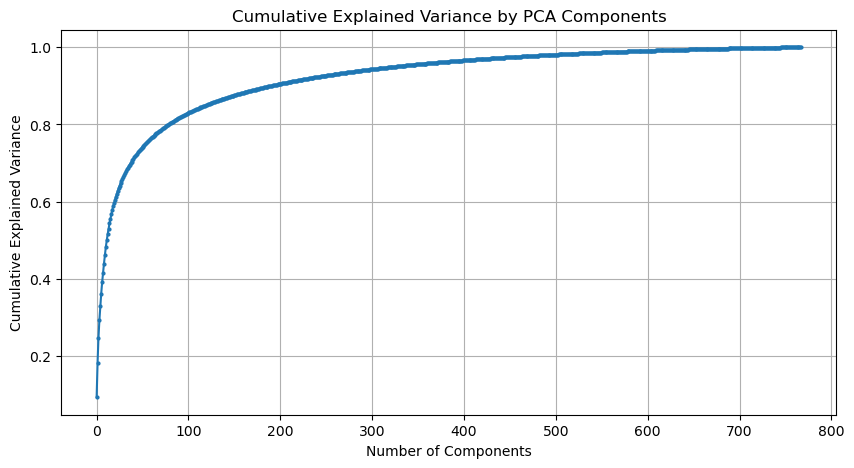

In [13]:
from sklearn.decomposition import PCA

pca_full = PCA()
pca_full.fit(embeddings_scaled)

cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)

plt.figure(figsize=(10, 5))
plt.plot(cumulative_variance, marker='o', markersize=2)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by PCA Components')
plt.grid(True)
plt.show()

In [14]:
variance_threshold = 0.90
components_for_threshold = np.where(cumulative_variance >= variance_threshold)[0][0] + 1

print(f"Number of components needed to explain {variance_threshold*100}% of variance: {components_for_threshold}")

pca_optimal = PCA(n_components=components_for_threshold)
pca_features = pca_optimal.fit_transform(embeddings_scaled)

#np.save('reduced_features.npy', reduced_features)
print(f"Reduced features shape: {pca_features.shape}")

Number of components needed to explain 90.0% of variance: 191
Reduced features shape: (15557, 768)


In [16]:
reducer = umap.UMAP(n_components=200, random_state=42)
umap_features = reducer.fit_transform(embeddings_scaled)

print(f"Reduced features shape: {umap_features.shape}")

/home/igor/anaconda3/envs/dermnet/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Reduced features shape: (15557, 3)


In [ ]:
pca_scaler, umap_scaler = StandardScaler(), StandardScaler()
pca_features, umap_features = pca_scaler.fit_transform(pca_features), umap_scaler.fit_transform(umap_features)

## Clustering

In [50]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

def calculate_metrics(features, cluster_labels):
    silhouette = silhouette_score(features, cluster_labels) 
    dbi = davies_bouldin_score(features, cluster_labels)
    ch = calinski_harabasz_score(features, cluster_labels)
    
    return silhouette, dbi, ch

def clustering_report(features, cluster_labels):
    silhouette, dbi, ch = calculate_metrics(features, cluster_labels)
    
    print(f"Number of clusters: {len(np.unique(cluster_labels))}")
    print(f"Silhouette Score: {silhouette}")
    print(f"Davies-Bouldin Index: {dbi}")
    print(f"Calinski-Harabasz Index: {ch}")
    

def plot_metrics(param_range, silhouette_scores, dbi_scores, ch_scores, param_name):
    plt.figure(figsize=(14, 10))
    
    plt.subplot(2, 2, 1)
    plt.plot(param_range, silhouette_scores, marker='o')
    plt.xlabel(param_name)
    plt.ylabel('Silhouette Score')
    plt.title(f'Silhouette Score by {param_name}')
    plt.grid(True)
    
    plt.subplot(2, 2, 2)
    plt.plot(param_range, dbi_scores, marker='o')
    plt.xlabel(param_name)
    plt.ylabel('Davies-Bouldin Index')
    plt.title(f'Davies-Bouldin Index by {param_name}')
    plt.grid(True)
    
    plt.subplot(2, 2, 3)
    plt.plot(param_range, ch_scores, marker='o')
    plt.xlabel(param_name)
    plt.ylabel('Calinski-Harabasz Index')
    plt.title(f'Calinski-Harabasz Index by {param_name}')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_clusters(cluster_labels, dataset):
    clusters = np.unique(cluster_labels)
    
    for cluster in clusters:
        indices = np.where(cluster_labels == cluster)[0]
        indices = indices[:5]
        
        plt.figure(figsize=(15, 5))
        for i, index in enumerate(indices):
            image, _ = dataset[index]
            image = image.permute(1, 2, 0).numpy()
            plt.subplot(1, 5, i+1)
            plt.imshow(image)
            plt.axis('off')
        
        plt.suptitle(f'Cluster {cluster}')
        plt.show()

### K-means

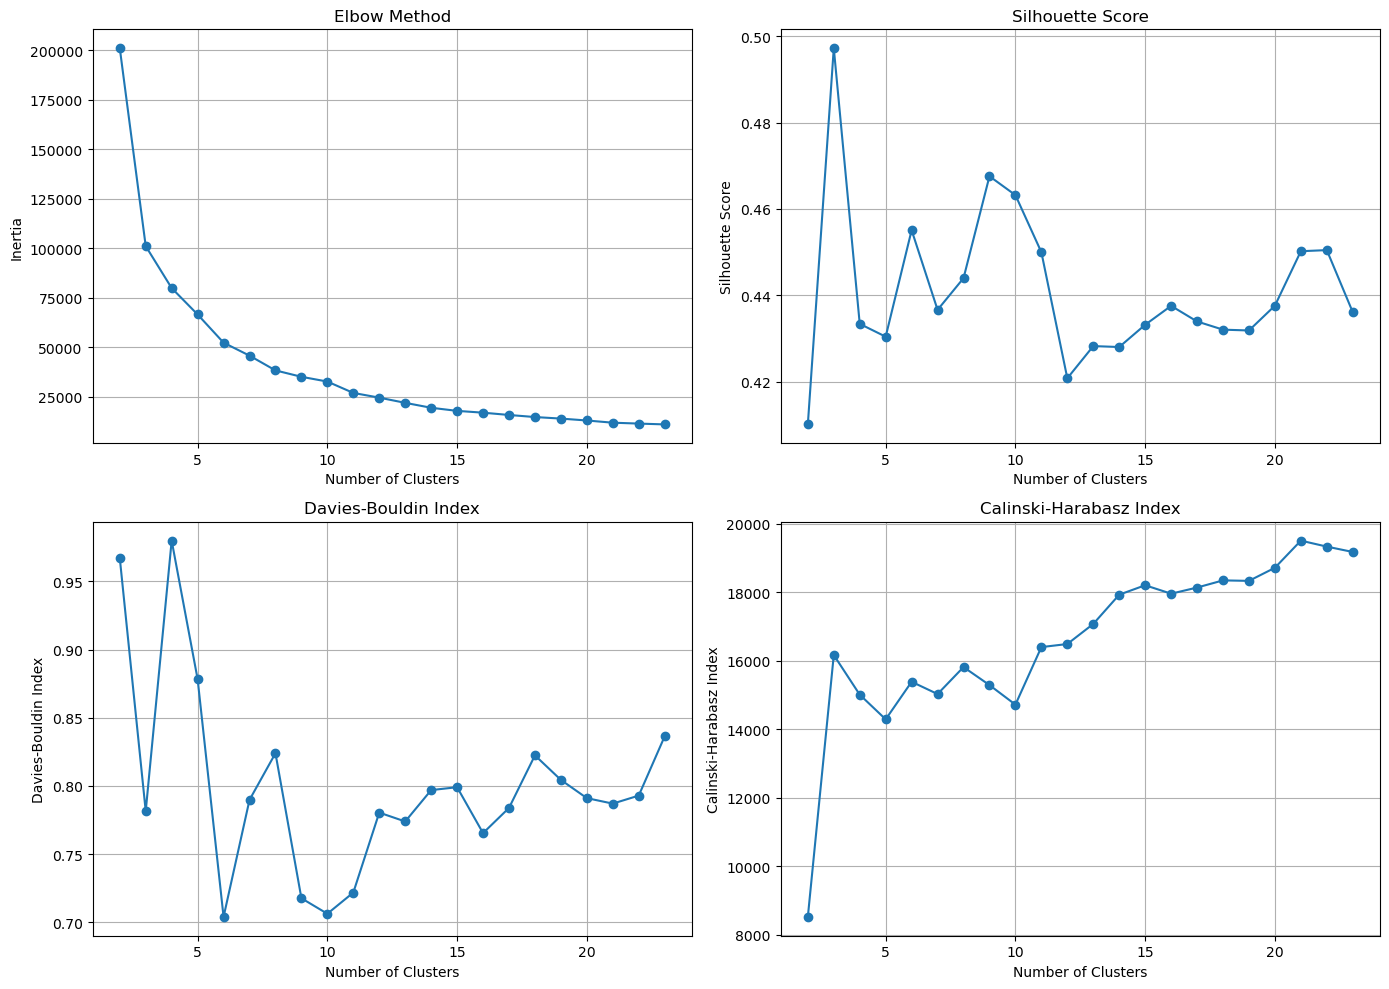

In [40]:
from sklearn.cluster import KMeans

reduced_features = umap_features

#scale reduces features
scaler2 = StandardScaler()
reduced_features_scaled = scaler2.fit_transform(reduced_features)

K_range = range(2, 24)

inertias = []
silhouette_scores = []
dbi_scores = []
ch_scores = []

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(reduced_features)
    
    inertias.append(kmeans.inertia_)
    silhouette, dbi, ch = calculate_metrics(reduced_features, cluster_labels)
    silhouette_scores.append(silhouette)
    dbi_scores.append(dbi)
    ch_scores.append(ch)

plt.figure(figsize=(14, 10))

plt.subplot(2, 2, 1)
plt.plot(K_range, inertias, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('WCSS')
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(K_range, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score')
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(K_range, dbi_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Davies-Bouldin Index')
plt.title('Davies-Bouldin Index')
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(K_range, ch_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Calinski-Harabasz Index')
plt.title('Calinski-Harabasz Index')
plt.grid(True)

plt.tight_layout()
plt.show()

### HDBSCAN

In [52]:
from sklearn.cluster import HDBSCAN

clusterer = HDBSCAN(min_cluster_size=300, min_samples=6)
cluster_labels = clusterer.fit_predict(umap_features)

clustering_report(umap_features, cluster_labels)

Number of clusters: 8
Silhouette Score: 0.23880518972873688
Davies-Bouldin Index: 1.6761700167380544
Calinski-Harabasz Index: 5861.298549373747


### DBSCAN

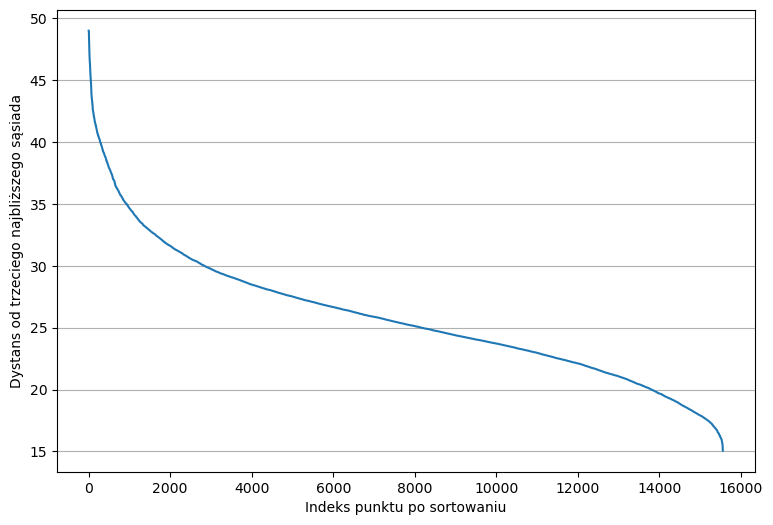

In [38]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

minPts = 200
nbrs = NearestNeighbors(n_neighbors=minPts).fit(embeddings_scaled)
distances, indices = nbrs.kneighbors(embeddings_scaled)
distanceDec = sorted(distances[:,minPts-1], reverse=True)
fig = plt.figure(figsize=(9,6))
ax1 = fig.add_subplot(111)

plt.xlabel('Indeks punktu po sortowaniu')
plt.ylabel('Dystans od trzeciego najbliższego sąsiada')
ax1.plot(list(range(1,embeddings_scaled.shape[0]+1)), distanceDec)

#plt.xscale('log')
plt.grid(axis='y')

plt.show()

In [39]:
dbscan = DBSCAN(eps=30, min_samples=150)

cluster_labels = dbscan.fit_predict(embeddings_scaled)

print(f"Number of clusters: {len(np.unique(cluster_labels))}")

Number of clusters: 3


### Agglomerative clustering